In [ ]:
!pip install optuna
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from catboost import Pool, CatBoostClassifier

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
df = pd.read_csv('data.csv')
df.head()

,Review,Rating
0,This film is an absolute classic for camp. Tha...,7
1,Like many of you I am a great fan of the real ...,9
2,An excellent depiction of one of the more unwh...,10
3,"Like I said at the top, four stars just aren't...",10
4,The influence of Hal Hartley in Adrienne Shell...,9


## Обработка данных

In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_review(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'https?://\S+|www\.\S+','',text)
    text = re.sub(r'[^a-zA-z0-9\s]', ' ', text).lower()
    tokens = text.split()
    return " ".join([lemmatizer.lemmatize(word) for word in tokens if word not in stop_words])

df['Review'] = df['Review'].apply(clean_review)
df.head()

,Review,Rating
0,film absolute classic camp elvira mst3000 clas...,7
1,like many great fan real thing 1940s noir film...,9
2,excellent depiction one unwholesome aspect era...,10
3,like said top four star enough one best film e...,10
4,influence hal hartley adrienne shelly take ove...,9


## EDA

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  50000 non-null  object
 1   Rating  50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


In [ ]:
pivot = pd.pivot_table(df,
                       index='Rating',
                       values='Review',
                       aggfunc='count')
pivot

,Review
Rating,
1,10122
2,4586
3,4961
4,5331
7,4803
8,5859
9,4607
10,9731


Из сводной таблицы видно что отзывы для рейтинга 5, 6 отсутствуют.\
Построим распределение оценок

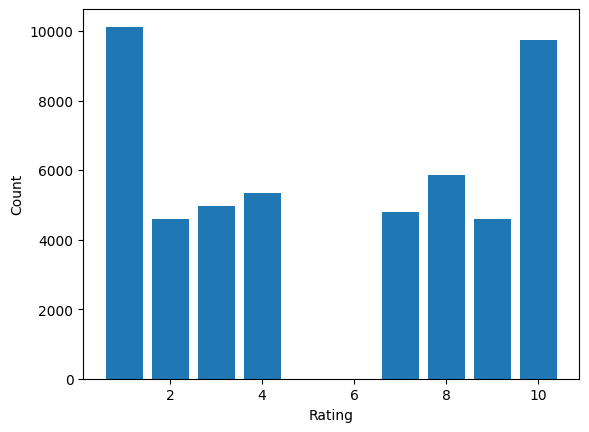

In [ ]:
plt.bar(x=pivot.index, height=pivot['Review'])
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

На графике отчетливо видно, что классы распределены не равномерно\
Постмотрим на расспределение колличества слов

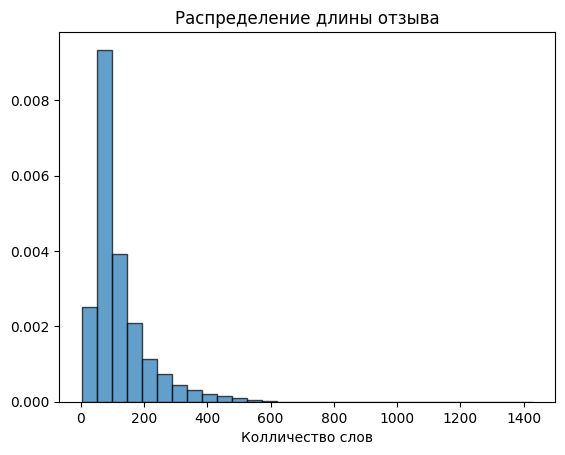

In [ ]:
df['word_count'] = np.array(df['Review'].apply(lambda x: len(str(x).split())))

plt.hist(df['word_count'], bins=30, density=True, alpha=0.7, edgecolor='black')
plt.title('Распределение длины отзыва')
plt.xlabel('Колличество слов')
plt.show()

Анализ выбросов

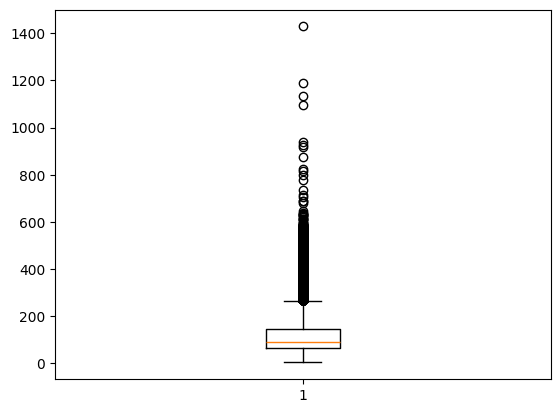

In [ ]:
plt.boxplot(df['word_count'])
plt.show()

В основном пользователи писали отзывы длиной не более 500 слов, но есть так же очень сильные выбросы которые надо будет почистить, тк они не поместятся в ембединг при обучении модели\
Посмотрим на среднюю длину отзыва для каждой оценки

In [ ]:
df.groupby('Rating')['word_count'].mean()

,word_count
Rating,
1,106.318415
2,117.542085
3,128.095948
4,130.531232
7,135.667083
8,130.351254
9,125.585414
10,106.819751


Видно что при крайних оценках пользователи склонны писать более короткие отзывы

Разделим на тестовую и обучающую выборку

In [ ]:
X = df['Review']
y = df['Rating']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

В качестве первого подхода векторизации теста попробуем $\text{TF-IDF}$

In [ ]:
tfidf = TfidfVectorizer(max_features=5000)
X_train = tfidf.fit_transform(X_train.reset_index()['Review'])
X_test= tfidf.transform(X_test.reset_index()['Review'])

## Метрика

Здесь не подойдут обычные метрики так классы не сбалансированы и тональность подраземувает не полное попадание в класс, поэтому введем следующую метрику

$$M = \frac{\sum_{i=1}^{N} w(y_i) \cdot 2^{-|y_i-\hat{y_i}|^2}}{\sum_{i=1}^{N}w(y_i) }$$

где $$w_c=\frac{N}{K \cdot N_c}$$

$N$ - общее количество отзывов в датасете

$K$ - количество уникальных классов

$N_c$ - количество отзывов конкретного класса $c$

In [ ]:
def metric(y_true,y_pred):
  N_c = np.unique_counts(y_true)
  N = np.size(y_true)
  K = np.size(N_c[0])
  w_c = N / (K * N_c[1])
  weight_dict = dict(zip(N_c[0], w_c))
  w_y = np.array([weight_dict[y] for y in y_true])
  M = np.sum(w_y*np.exp2(-(y_true-y_pred)**2)) / np.sum(w_y)
  return M

score = make_scorer(metric, greater_is_better=True)

## Обучение стандартных моделей классификации

In [ ]:
import time

models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "Linear SVC": LinearSVC(class_weight='balanced', max_iter=2000),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced', max_depth=10)
}

results = []

for name, model in models.items():

  start = time.perf_counter()
  model.fit(X_train, y_train)
  finish = time.perf_counter()
  y_pred = model.predict(X_test)
  score = metric(y_test, y_pred)
  results.append({
      "Model": name,
      "Score": round(score, 5),
      "Training time": f'{round((finish - start), 5)} секунд'
  })
pd.DataFrame(results).sort_values(by="Score", ascending=False)

,Model,Score,Training time
0,Logistic Regression,0.51896,17.83762 секунд
2,Linear SVC,0.48920,8.20879 секунд
1,Naive Bayes,0.42336,0.05942 секунд
3,Decision Tree,0.34083,8.87697 секунд


## Обучение CatBoost

Среди остальных моделей градиентного бустинга CatBoost удобен тем, что сам способен обрабатывать текстовые данные

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y
)

def reset_all(df_or_ser):
    return df_or_ser.reset_index(drop=True)

X_train, y_train = reset_all(X_train), reset_all(y_train)
X_test, y_test   = reset_all(X_test),  reset_all(y_test)

In [ ]:
if not isinstance(X_train, pd.DataFrame):
    X_train = pd.DataFrame(X_train, columns=['Review'])
    X_test = pd.DataFrame(X_test, columns=['Review'])


train_pool = Pool(
    data=X_train,
    label=y_train,
    text_features=['Review']
)

test_pool = Pool(
    data=X_test,
    label=y_test,
    text_features=['Review']
)

model = CatBoostClassifier(
    iterations=5000,
    learning_rate=0.03,
    task_type="GPU",
    grow_policy='Lossguide',
    max_leaves=64,
    depth=8,
    l2_leaf_reg=5.0,
    random_strength=2.0,
    auto_class_weights='Balanced',
    loss_function='MultiClass',
    early_stopping_rounds=150,
    verbose=100
)

model.fit(train_pool, eval_set=test_pool)

0:	learn: 2.0503371	test: 2.0491637	best: 2.0491637 (0)	total: 75.4ms	remaining: 6m 16s
100:	learn: 1.5287078	test: 1.5196697	best: 1.5196697 (100)	total: 4.79s	remaining: 3m 52s
200:	learn: 1.4600601	test: 1.4756800	best: 1.4756800 (200)	total: 7.61s	remaining: 3m 1s
300:	learn: 1.4185678	test: 1.4577165	best: 1.4577165 (300)	total: 10.3s	remaining: 2m 41s
400:	learn: 1.3867206	test: 1.4470104	best: 1.4470104 (400)	total: 14.8s	remaining: 2m 50s
500:	learn: 1.3589636	test: 1.4398406	best: 1.4398406 (500)	total: 17.6s	remaining: 2m 37s
600:	learn: 1.3355964	test: 1.4347942	best: 1.4347942 (600)	total: 20.3s	remaining: 2m 28s
700:	learn: 1.3136820	test: 1.4306145	best: 1.4306145 (700)	total: 23.1s	remaining: 2m 21s
800:	learn: 1.2935394	test: 1.4276251	best: 1.4276251 (800)	total: 27.5s	remaining: 2m 24s
900:	learn: 1.2744447	test: 1.4250767	best: 1.4250767 (900)	total: 30.2s	remaining: 2m 17s
1000:	learn: 1.2564625	test: 1.4223042	best: 1.4223042 (1000)	total: 32.9s	remaining: 2m 11s
1

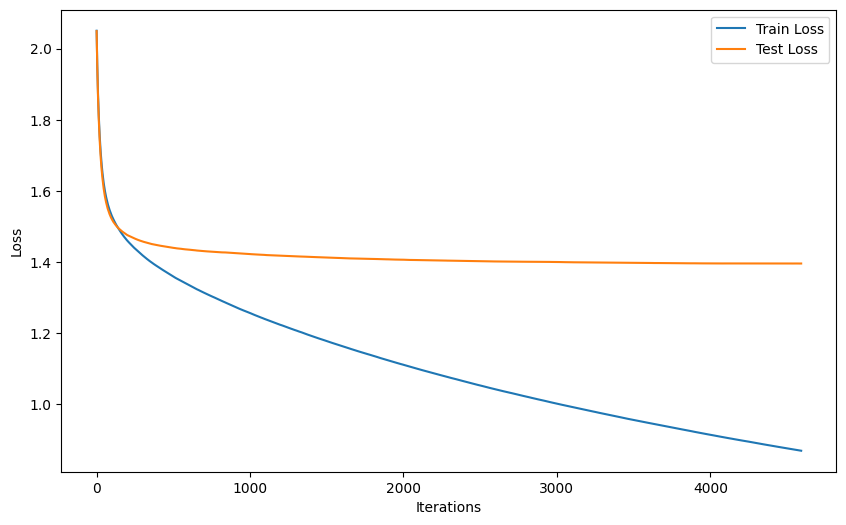

In [ ]:
evals = model.get_evals_result()
train_loss = evals['learn']['MultiClass']
test_loss = evals['validation']['MultiClass']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
y_pred = model.predict(test_pool).flatten().astype(int)
print(f'Score: {metric(y_test, y_pred)}')

Score: 0.588964586143779


Точность оценки тональности выросла по сравнению с LogRes